In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ParameterGrid

In [2]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
class CNNWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return train_losses, val_losses, val_accuracies

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Split training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 48000
Validation samples: 12000
Test samples: 10000


In [7]:
# Set hyperparameters
batch_size = 64
learning_rate = 0.01
epochs = 10

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize models
base_model = BaseCNN()
dropout_model = CNNWithDropout(dropout_rate=0.5)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
base_optimizer = optim.Adam(base_model.parameters(), lr=learning_rate)
dropout_optimizer = optim.Adam(dropout_model.parameters(), lr=learning_rate)

# Train base model
print("Training Base CNN (without Dropout):")
base_train_loss, base_val_loss, base_val_acc = train_model(
    base_model, train_loader, val_loader, base_optimizer, criterion, epochs
)

# Train dropout model
print("\nTraining CNN with Dropout:")
dropout_train_loss, dropout_val_loss, dropout_val_acc = train_model(
    dropout_model, train_loader, val_loader, dropout_optimizer, criterion, epochs
)

Training Base CNN (without Dropout):
Epoch 1/10, Train Loss: 0.1748, Val Loss: 0.1019, Val Acc: 97.04%
Epoch 2/10, Train Loss: 0.0806, Val Loss: 0.0804, Val Acc: 97.76%
Epoch 3/10, Train Loss: 0.0705, Val Loss: 0.0970, Val Acc: 97.12%
Epoch 4/10, Train Loss: 0.0627, Val Loss: 0.0792, Val Acc: 98.01%
Epoch 5/10, Train Loss: 0.0629, Val Loss: 0.0704, Val Acc: 98.27%
Epoch 6/10, Train Loss: 0.0624, Val Loss: 0.0846, Val Acc: 97.70%
Epoch 7/10, Train Loss: 0.0561, Val Loss: 0.0844, Val Acc: 97.99%
Epoch 8/10, Train Loss: 0.0484, Val Loss: 0.1005, Val Acc: 98.11%
Epoch 9/10, Train Loss: 0.0536, Val Loss: 0.1043, Val Acc: 97.62%
Epoch 10/10, Train Loss: 0.0518, Val Loss: 0.1064, Val Acc: 97.81%

Training CNN with Dropout:
Epoch 1/10, Train Loss: 0.2618, Val Loss: 0.1038, Val Acc: 97.02%
Epoch 2/10, Train Loss: 0.1559, Val Loss: 0.1062, Val Acc: 97.33%
Epoch 3/10, Train Loss: 0.1411, Val Loss: 0.1093, Val Acc: 97.26%
Epoch 4/10, Train Loss: 0.1398, Val Loss: 0.1158, Val Acc: 97.30%
Epoch 5/10

In [8]:
# Initialize model with batch normalization
batchnorm_model = CNNWithBatchNorm()
batchnorm_optimizer = optim.Adam(batchnorm_model.parameters(), lr=learning_rate)

# Train batch normalization model
print("\nTraining CNN with Batch Normalization:")
batchnorm_train_loss, batchnorm_val_loss, batchnorm_val_acc = train_model(
    batchnorm_model, train_loader, val_loader, batchnorm_optimizer, criterion, epochs
)


Training CNN with Batch Normalization:
Epoch 1/10, Train Loss: 0.2196, Val Loss: 0.0696, Val Acc: 97.98%
Epoch 2/10, Train Loss: 0.0589, Val Loss: 0.0593, Val Acc: 98.30%
Epoch 3/10, Train Loss: 0.0473, Val Loss: 0.0507, Val Acc: 98.55%
Epoch 4/10, Train Loss: 0.0397, Val Loss: 0.0667, Val Acc: 98.23%
Epoch 5/10, Train Loss: 0.0359, Val Loss: 0.0531, Val Acc: 98.65%
Epoch 6/10, Train Loss: 0.0325, Val Loss: 0.0715, Val Acc: 98.19%
Epoch 7/10, Train Loss: 0.0293, Val Loss: 0.0622, Val Acc: 98.45%
Epoch 8/10, Train Loss: 0.0273, Val Loss: 0.0667, Val Acc: 98.34%
Epoch 9/10, Train Loss: 0.0263, Val Loss: 0.0505, Val Acc: 98.80%
Epoch 10/10, Train Loss: 0.0264, Val Loss: 0.0651, Val Acc: 98.55%


In [9]:
# Define hyperparameter grid
param_grid = {
    'batch_size': [32, 64],
    'learning_rate': [0.001, 0.01],
    'optimizer': ['SGD', 'Adam']
}

# Perform grid search
results = []
best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    print(f"\nTesting parameters: {params}")
    
    # Create data loaders with current batch size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    
    # Initialize model
    model = CNNWithDropout(dropout_rate=0.5)
    
    # Select optimizer
    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])
    else:
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    # Train model
    criterion = nn.CrossEntropyLoss()
    train_loss, val_loss, val_acc = train_model(
        model, train_loader, val_loader, optimizer, criterion, epochs=5
    )
    
    # Record results
    result = {
        'params': params,
        'final_val_accuracy': val_acc[-1],
        'final_val_loss': val_loss[-1],
        'val_accuracies': val_acc,
        'val_losses': val_loss
    }
    results.append(result)
    
    # Update best parameters
    if val_acc[-1] > best_accuracy:
        best_accuracy = val_acc[-1]
        best_params = params

print(f"\nBest parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.2f}%")


Testing parameters: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'SGD'}
Epoch 1/5, Train Loss: 2.1373, Val Loss: 1.6794, Val Acc: 71.58%
Epoch 2/5, Train Loss: 1.0089, Val Loss: 0.5111, Val Acc: 86.70%
Epoch 3/5, Train Loss: 0.5419, Val Loss: 0.3571, Val Acc: 89.93%
Epoch 4/5, Train Loss: 0.4287, Val Loss: 0.2960, Val Acc: 91.22%
Epoch 5/5, Train Loss: 0.3695, Val Loss: 0.2566, Val Acc: 92.17%

Testing parameters: {'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'Adam'}
Epoch 1/5, Train Loss: 0.2330, Val Loss: 0.0672, Val Acc: 97.98%
Epoch 2/5, Train Loss: 0.0897, Val Loss: 0.0532, Val Acc: 98.44%
Epoch 3/5, Train Loss: 0.0686, Val Loss: 0.0475, Val Acc: 98.62%
Epoch 4/5, Train Loss: 0.0547, Val Loss: 0.0453, Val Acc: 98.72%
Epoch 5/5, Train Loss: 0.0474, Val Loss: 0.0448, Val Acc: 98.66%

Testing parameters: {'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'SGD'}
Epoch 1/5, Train Loss: 0.6149, Val Loss: 0.1713, Val Acc: 94.69%
Epoch 2/5, Train Loss: 0.1997, Va

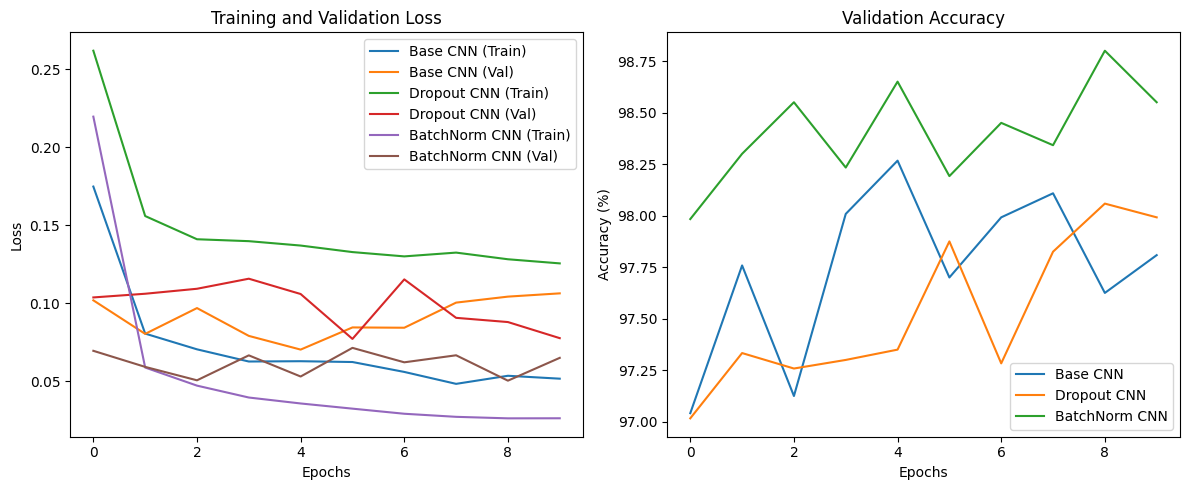

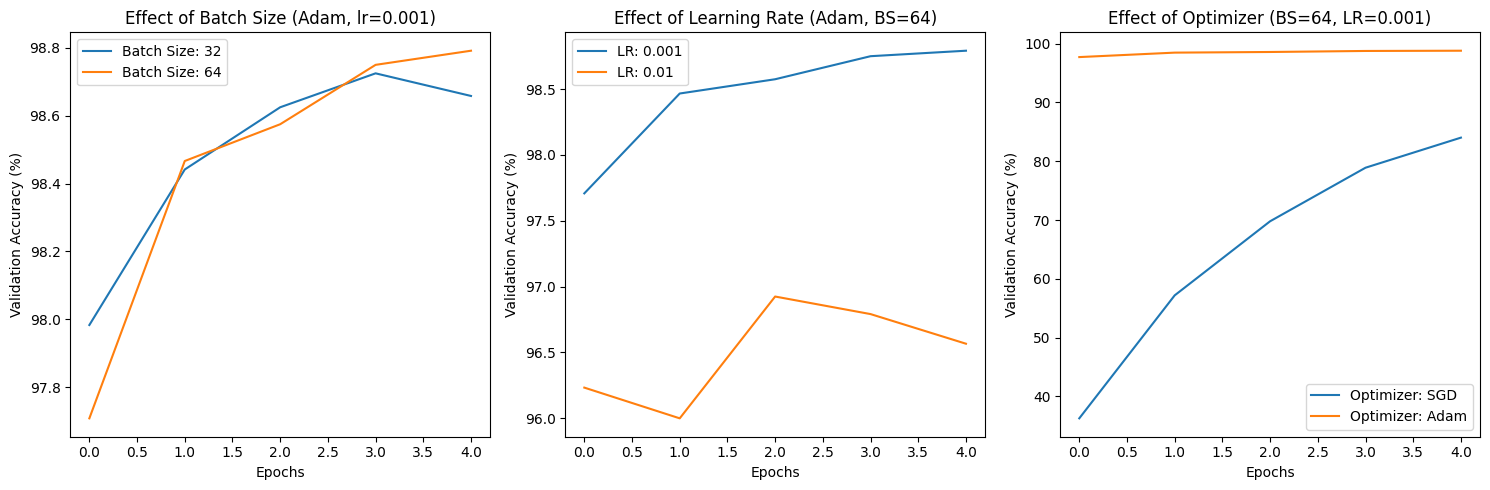

In [10]:
# Plot training and validation loss for different models
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(base_train_loss, label='Base CNN (Train)')
plt.plot(base_val_loss, label='Base CNN (Val)')
plt.plot(dropout_train_loss, label='Dropout CNN (Train)')
plt.plot(dropout_val_loss, label='Dropout CNN (Val)')
plt.plot(batchnorm_train_loss, label='BatchNorm CNN (Train)')
plt.plot(batchnorm_val_loss, label='BatchNorm CNN (Val)')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(base_val_acc, label='Base CNN')
plt.plot(dropout_val_acc, label='Dropout CNN')
plt.plot(batchnorm_val_acc, label='BatchNorm CNN')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot hyperparameter tuning results
plt.figure(figsize=(15, 5))

# Batch size comparison
plt.subplot(1, 3, 1)
for batch_size in [32, 64]:
    batch_results = [r for r in results if r['params']['batch_size'] == batch_size and r['params']['optimizer'] == 'Adam' and r['params']['learning_rate'] == 0.001]
    if batch_results:
        plt.plot(batch_results[0]['val_accuracies'], label=f'Batch Size: {batch_size}')
plt.title('Effect of Batch Size (Adam, lr=0.001)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.legend()

# Learning rate comparison
plt.subplot(1, 3, 2)
for lr in [0.001, 0.01]:
    lr_results = [r for r in results if r['params']['learning_rate'] == lr and r['params']['optimizer'] == 'Adam' and r['params']['batch_size'] == 64]
    if lr_results:
        plt.plot(lr_results[0]['val_accuracies'], label=f'LR: {lr}')
plt.title('Effect of Learning Rate (Adam, BS=64)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.legend()

# Optimizer comparison
plt.subplot(1, 3, 3)
for optimizer in ['SGD', 'Adam']:
    opt_results = [r for r in results if r['params']['optimizer'] == optimizer and r['params']['batch_size'] == 64 and r['params']['learning_rate'] == 0.001]
    if opt_results:
        plt.plot(opt_results[0]['val_accuracies'], label=f'Optimizer: {optimizer}')
plt.title('Effect of Optimizer (BS=64, LR=0.001)')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Train final model with best parameters
final_train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
final_val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

final_model = CNNWithDropout(dropout_rate=0.5)

if best_params['optimizer'] == 'SGD':
    final_optimizer = optim.SGD(final_model.parameters(), lr=best_params['learning_rate'])
else:
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

print(f"Training final model with parameters: {best_params}")
final_train_loss, final_val_loss, final_val_acc = train_model(
    final_model, final_train_loader, final_val_loader, final_optimizer, criterion, epochs=10
)

# Evaluate on test set
final_model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Training final model with parameters: {'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'Adam'}
Epoch 1/10, Train Loss: 0.2829, Val Loss: 0.0737, Val Acc: 97.70%
Epoch 2/10, Train Loss: 0.0994, Val Loss: 0.0574, Val Acc: 98.18%
Epoch 3/10, Train Loss: 0.0729, Val Loss: 0.0483, Val Acc: 98.63%
Epoch 4/10, Train Loss: 0.0620, Val Loss: 0.0435, Val Acc: 98.80%
Epoch 5/10, Train Loss: 0.0555, Val Loss: 0.0446, Val Acc: 98.70%
Epoch 6/10, Train Loss: 0.0464, Val Loss: 0.0469, Val Acc: 98.81%
Epoch 7/10, Train Loss: 0.0414, Val Loss: 0.0425, Val Acc: 98.92%
Epoch 8/10, Train Loss: 0.0362, Val Loss: 0.0491, Val Acc: 98.69%
Epoch 9/10, Train Loss: 0.0327, Val Loss: 0.0439, Val Acc: 98.99%
Epoch 10/10, Train Loss: 0.0287, Val Loss: 0.0414, Val Acc: 98.97%
Test Accuracy: 99.12%
